In [111]:
#Importing dependencies and defines constants for a TensorFlow image classification project.
import tensorflow as tf
from tensorflow.keras import models, layers
from IPython.display import HTML
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
import seaborn as sns

#Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50



In [2]:
#Using image_dataset_from_directory api to load all images in tensorflow dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

#Checking different categories/directories
class_names = dataset.class_names
class_names

Found 8862 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [33]:
#Output of images name of batch 20 and total batches 
batch_number = 21
for i, (images, labels) in enumerate(dataset):
    if i == batch_number:
        image_names = dataset.file_paths[:10]
        print("Image names for batch 20:", image_names)
        break

print("\nTotal batches are : ", len(dataset))

Image names for batch 20: ['Potato_Images\\Potato___Early_blight\\Early_Blight_472.jpg', 'Potato_Images\\Potato___Early_blight\\EarlyBlight_365.jpg', 'Potato_Images\\Potato___Late_blight\\LateBlight_657.jpg', 'Potato_Images\\Potato___Early_blight\\EarlyBlight_1142.jpg', 'Potato_Images\\Potato___Early_blight\\EarlyBlight_1424.jpg', 'Potato_Images\\Potato___Late_blight\\Late_Blight_509.jpg', 'Potato_Images\\Potato___Late_blight\\ede8e8be-6d71-466e-918e-44afa1403e30___RS_LB 5455.JPG', 'Potato_Images\\Potato___Late_blight\\LateBlight_190.jpg', 'Potato_Images\\Potato___Early_blight\\EarlyBlight_1070.jpg', 'Potato_Images\\Potato___Early_blight\\EarlyBlight_739.jpg']

Total batches are :  277


In [30]:
#Image batch and labels, 0 is early blight, 1 is healthy and 2 is late blight
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 2 0 2 0 0 0 0 1 1 0 2 0 0 1 1 0 2 0 1 1 0 1 1 1 1 1 1 1 1 1]


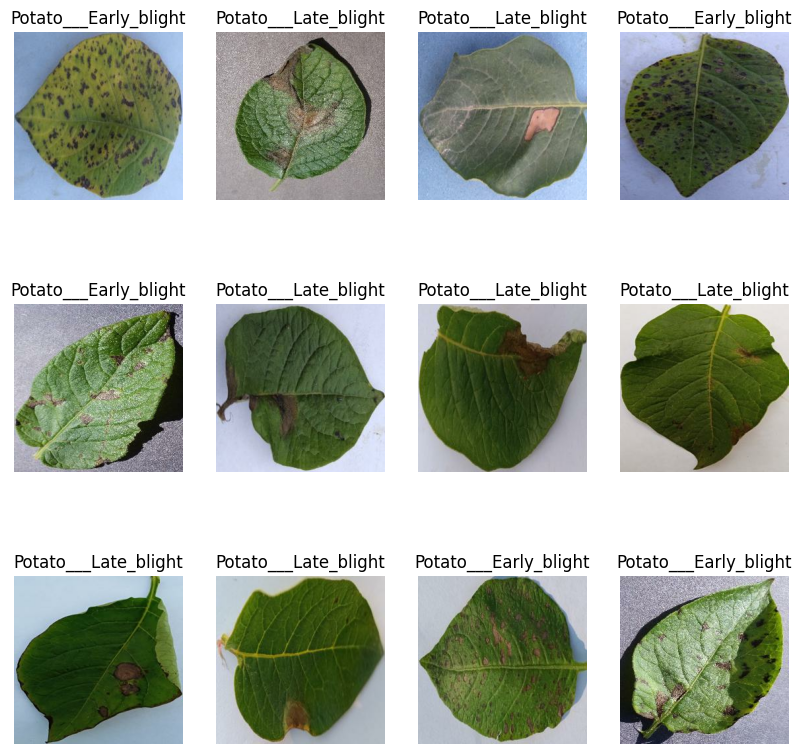

In [3]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

277

In [113]:
#defines a function to split a TensorFlow dataset into training, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

221
27
29


In [114]:
#caches, shuffles, and prefetches the training, validation, and test datasets for optimized performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



#defines sequential models for resizing/rescaling and augmenting the images.
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])


In [116]:

#defines and builds a sequential convolutional neural network (CNN) model for image classification, incorporating resizing, rescaling
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3


#multiple convolutional and max-pooling layers, followed by fully connected layers
#also output layer with softmax activation for class prediction.
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [38]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [117]:
# compiles the model with the Adam optimizer
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
#This code block trains the model using the training dataset , validates using the validation dataset
#runs for 60 epochs, displaying progress with verbosity set to 1.
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=60,
)

Epoch 1/60
221/221 [==============================] - 43s 145ms/step - loss: 0.8883 - accuracy: 0.5543 - val_loss: 0.5711 - val_accuracy: 0.7639
Epoch 2/60
221/221 [==============================] - 16s 64ms/step - loss: 0.4328 - accuracy: 0.8363 - val_loss: 0.2069 - val_accuracy: 0.9306
Epoch 3/60
221/221 [==============================] - 12s 56ms/step - loss: 0.2685 - accuracy: 0.9059 - val_loss: 0.2429 - val_accuracy: 0.9236
Epoch 4/60
221/221 [==============================] - 12s 56ms/step - loss: 0.1695 - accuracy: 0.9416 - val_loss: 0.1064 - val_accuracy: 0.9641
Epoch 5/60
221/221 [==============================] - 12s 56ms/step - loss: 0.1342 - accuracy: 0.9527 - val_loss: 0.1369 - val_accuracy: 0.9572
Epoch 6/60
221/221 [==============================] - 12s 56ms/step - loss: 0.1177 - accuracy: 0.9577 - val_loss: 0.0862 - val_accuracy: 0.9722
Epoch 7/60
221/221 [==============================] - 12s 56ms/step - loss: 0.0757 - accuracy: 0.9755 - val_loss: 0.0852 - val_accuracy

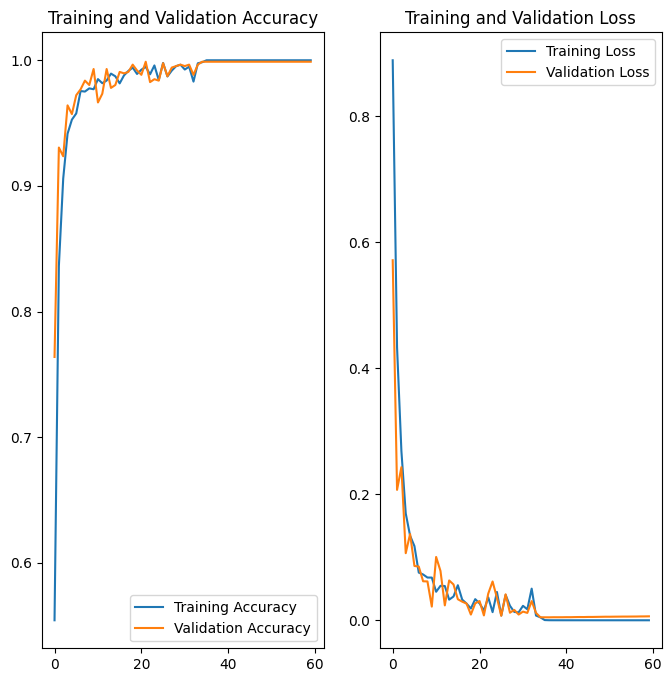

In [42]:
EPOCHS = 60
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
# Learning rates to experiment with
learning_rates = [0.001, 0.01, 0.1]

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

# Load dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

def save_history_to_txt(history, filename):
    with open(filename, 'w') as f:
        for key, value in history.items():
            f.write(f"{key}: {value}\n")
            
def create_model():
    input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    n_classes = 3
    
    model = models.Sequential([
        resize_and_rescale,
        layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax'),
    ])
    
    model.build(input_shape=input_shape)
    return model

# Function to train models with different learning rates
def train_model_with_lr(learning_rate):
    model = create_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    history = model.fit(train_ds,
                        batch_size=BATCH_SIZE,
                        validation_data=val_ds,
                        epochs=30,
                        verbose=1)  
    return history.history, model


In [9]:
# Train model 1 with different learning rates and generate results
results_1 = []
models_1 = []

for lr in learning_rates:
    print(f"For learning rate {lr} :- ")
    model_results_1 = {}
    model_losses_1 = []

    model_history_1, model_1 = train_model_with_lr(lr)

    # Save history to text file for model 1
    save_history_to_txt(model_history_1, f'/History/model_1_lr_{lr}_history.txt')

    # Save model
    tf.saved_model.save(model_1, f"../Models/model_1_lr_{lr}")

    model_dir = "../Models/.keras"
    model_1.save(os.path.join(model_dir, f"model_1_lr_{lr}.keras"))

    # Store model results for model 1
    model_results_1[f'Model 1, LR {lr}'] = {
        'Training Loss': model_history_1['loss'][-1],
        'Validation Loss': model_history_1['val_loss'][-1],
        'Training Accuracy': model_history_1['accuracy'][-1],
        'Validation Accuracy': model_history_1['val_accuracy'][-1]
    }

    # Store model losses for model 1
    model_losses_1.append(model_history_1)

    # Append model results and losses for model 1
    results_1.append(model_results_1)
    models_1.append((model_1, model_losses_1))


For learning rate 0.001 :- 
Epoch 1/30
54/54 [==============================] - 5s 71ms/step - loss: 0.9022 - accuracy: 0.4842 - val_loss: 0.8449 - val_accuracy: 0.5052
Epoch 2/30
54/54 [==============================] - 4s 68ms/step - loss: 0.7888 - accuracy: 0.5915 - val_loss: 0.7606 - val_accuracy: 0.6369
Epoch 3/30
54/54 [==============================] - 4s 69ms/step - loss: 0.6547 - accuracy: 0.7066 - val_loss: 0.4692 - val_accuracy: 0.8125
Epoch 4/30
54/54 [==============================] - 5s 71ms/step - loss: 0.4404 - accuracy: 0.8022 - val_loss: 0.3613 - val_accuracy: 0.8750
Epoch 5/30
54/54 [==============================] - 4s 68ms/step - loss: 0.3971 - accuracy: 0.8269 - val_loss: 0.2922 - val_accuracy: 0.9010
Epoch 6/30
54/54 [==============================] - 4s 69ms/step - loss: 0.2969 - accuracy: 0.8709 - val_loss: 0.2090 - val_accuracy: 0.9219
Epoch 7/30
54/54 [==============================] - 4s 68ms/step - loss: 0.2625 - accuracy: 0.8903 - val_loss: 0.2149 - val_ac

INFO:tensorflow:Assets written to: ../Models/model_1_lr_0.001\assets


INFO:tensorflow:Assets written to: ../Models/model_1_lr_0.001\assets


For learning rate 0.01 :- 
Epoch 1/30
54/54 [==============================] - 5s 70ms/step - loss: 0.9550 - accuracy: 0.4759 - val_loss: 0.9398 - val_accuracy: 0.4427
Epoch 2/30
54/54 [==============================] - 4s 67ms/step - loss: 0.9015 - accuracy: 0.4800 - val_loss: 0.9816 - val_accuracy: 0.4479
Epoch 3/30
54/54 [==============================] - 4s 66ms/step - loss: 0.9130 - accuracy: 0.4671 - val_loss: 0.8977 - val_accuracy: 0.4635
Epoch 4/30
54/54 [==============================] - 4s 69ms/step - loss: 0.9046 - accuracy: 0.4736 - val_loss: 1.0069 - val_accuracy: 0.4271
Epoch 5/30
54/54 [==============================] - 5s 76ms/step - loss: 0.9083 - accuracy: 0.4636 - val_loss: 0.8894 - val_accuracy: 0.4688
Epoch 6/30
54/54 [==============================] - 5s 71ms/step - loss: 0.9024 - accuracy: 0.4437 - val_loss: 0.9259 - val_accuracy: 0.4740
Epoch 7/30
54/54 [==============================] - 5s 74ms/step - loss: 0.9057 - accuracy: 0.4390 - val_loss: 0.8582 - val_acc

INFO:tensorflow:Assets written to: ../Models/model_1_lr_0.01\assets


INFO:tensorflow:Assets written to: ../Models/model_1_lr_0.01\assets


For learning rate 0.1 :- 
Epoch 1/30
54/54 [==============================] - 5s 70ms/step - loss: 124007.7969 - accuracy: 0.4531 - val_loss: 0.8543 - val_accuracy: 0.5052
Epoch 2/30
54/54 [==============================] - 4s 66ms/step - loss: 0.9022 - accuracy: 0.4560 - val_loss: 0.8800 - val_accuracy: 0.4531
Epoch 3/30
54/54 [==============================] - 4s 66ms/step - loss: 0.9046 - accuracy: 0.4536 - val_loss: 0.9140 - val_accuracy: 0.4948
Epoch 4/30
54/54 [==============================] - 4s 68ms/step - loss: 0.9117 - accuracy: 0.4636 - val_loss: 0.8991 - val_accuracy: 0.4271
Epoch 5/30
54/54 [==============================] - 5s 71ms/step - loss: 0.8971 - accuracy: 0.4789 - val_loss: 0.8529 - val_accuracy: 0.4792
Epoch 6/30
54/54 [==============================] - 4s 69ms/step - loss: 0.9136 - accuracy: 0.4531 - val_loss: 0.9180 - val_accuracy: 0.4167
Epoch 7/30
54/54 [==============================] - 4s 69ms/step - loss: 0.9049 - accuracy: 0.4525 - val_loss: 0.9148 - val

INFO:tensorflow:Assets written to: ../Models/model_1_lr_0.1\assets


INFO:tensorflow:Assets written to: ../Models/model_1_lr_0.1\assets


In [8]:
# Define learning rates and paths to history files
learning_rates = [0.001, 0.01, 0.1]
history_files = ["History/model_1_lr_0.001_history.txt", "History/model_1_lr_0.01_history.txt", "History/model_1_lr_0.1_history.txt"]

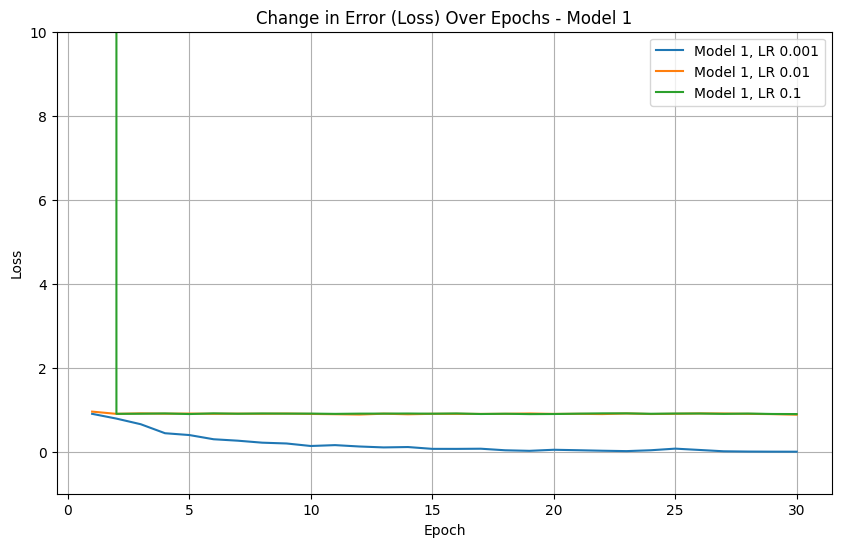

In [15]:
import re
plt.figure(figsize=(10, 6))

for i, history_file in enumerate(history_files):
    lr = learning_rates[i]
    epochs = []
    losses = []
    with open(history_file, 'r') as file:
        for line in file:
            # Split the line based on ":"
            parts = line.split(":")
            # Check if the line contains loss data
            if parts[0].strip() == "loss":
                # Extract the values and remove any non-numeric characters
                values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[1])
                # Convert the values to floats and append to losses
                losses = [float(val) for val in values]
                epochs = list(range(1, len(losses) + 1))

                plt.plot(epochs, losses, label=f'Model 1, LR {lr}')  # Plot loss from history file

plt.title('Change in Error (Loss) Over Epochs - Model 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(-1, 10)  # Set y-axis limits
plt.show()

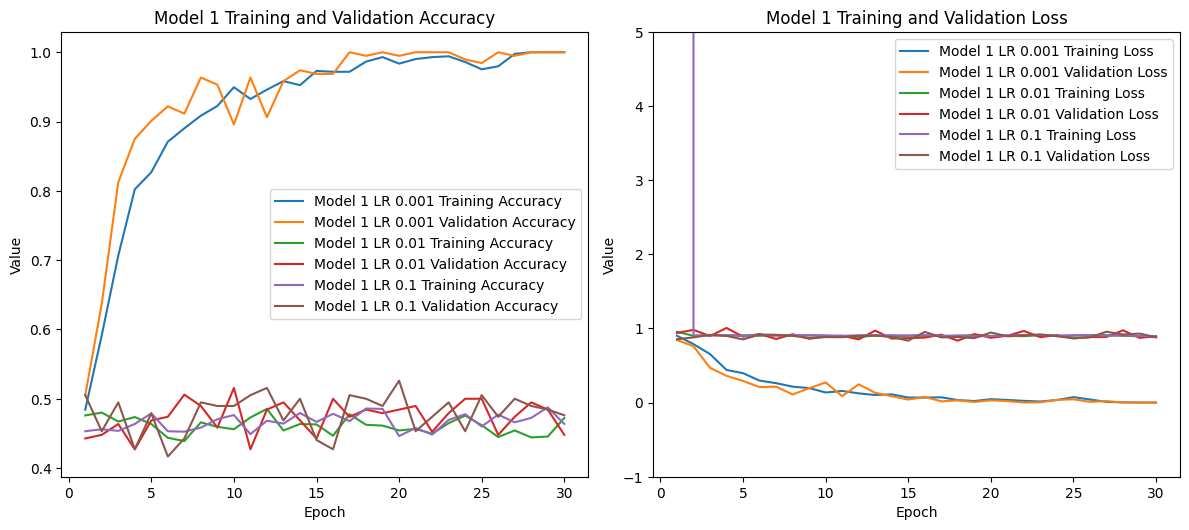

In [18]:
plt.figure(figsize=(12, 10))

for i, history_file in enumerate(history_files):
    lr = learning_rates[i]
    epochs = []
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    with open(history_file, 'r') as file:
        for line in file:
            # Split the line based on ":"
            parts = line.split(":")
            # Check if the line contains loss data
            if parts[0].strip() == "loss":
                # Extract the values and remove any non-numeric characters
                values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[1])
                # Convert the values to floats and append to loss
                loss = [float(val) for val in values]
            elif parts[0].strip() == "accuracy":
                values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[1])
                acc = [float(val) for val in values]
            elif parts[0].strip() == "val_loss":
                values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[1])
                val_loss = [float(val) for val in values]
            elif parts[0].strip() == "val_accuracy":
                values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[1])
                val_acc = [float(val) for val in values]

        epochs = list(range(1, len(loss) + 1))

        plt.subplot(2, 2, 1)
        plt.plot(epochs, acc[:len(epochs)], label=f'Model 1 LR {lr} Training Accuracy')
        plt.plot(epochs, val_acc[:len(epochs)], label=f'Model 1 LR {lr} Validation Accuracy')

        plt.subplot(2, 2, 2)
        plt.plot(epochs, loss[:len(epochs)], label=f'Model 1 LR {lr} Training Loss')
        plt.plot(epochs, val_loss[:len(epochs)], label=f'Model 1 LR {lr} Validation Loss')
        plt.ylim(-1, 5)  # Set y-axis limit for validation loss

# Set labels and legends
for i in range(1, 3):
    plt.subplot(2, 2, i)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

# Set titles
plt.subplot(2, 2, 1)
plt.title('Model 1 Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.title('Model 1 Training and Validation Loss')

plt.tight_layout()
plt.show()

In [7]:
model = tf.keras.models.load_model('../Models/.keras/Alpha.keras')

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy*100:.2f}%')


29/29 [==============================] - 16s 22ms/step - loss: 3.6586e-04 - accuracy: 1.0000
Test accuracy: 100.00%


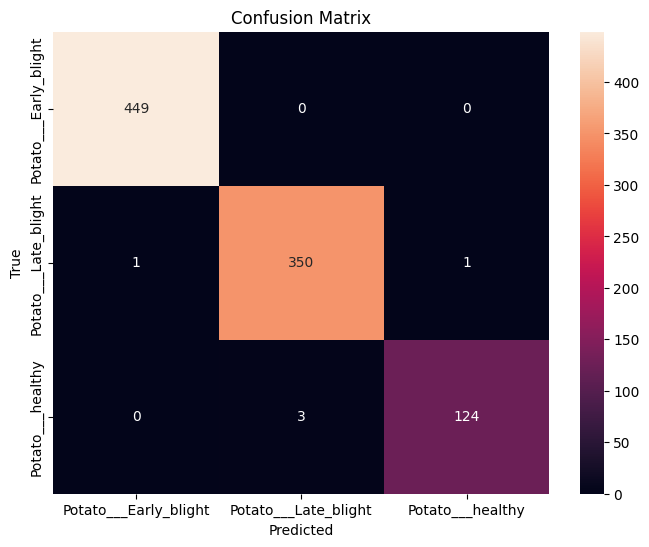

Accuracy: 0.99
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       449
 Potato___Late_blight       0.99      0.99      0.99       352
     Potato___healthy       0.99      0.98      0.98       127

             accuracy                           0.99       928
            macro avg       0.99      0.99      0.99       928
         weighted avg       0.99      0.99      0.99       928

Error rate: 0.01

Class: Potato___Early_blight
True Positives (TP): 449
False Positives (FP): 1
True Negatives (TN): 478
False Negatives (FN): 0
Precision: 1.00
Recall: 1.00
F1 Score: 1.00

Class: Potato___Late_blight
True Positives (TP): 350
False Positives (FP): 3
True Negatives (TN): 573
False Negatives (FN): 2
Precision: 0.99
Recall: 0.99
F1 Score: 0.99

Class: Potato___healthy
True Positives (TP): 124
False Positives (FP): 1
True Negatives (TN): 800
False Negatives (FN): 3
Precision: 0.99
Recall: 0.98
F1 Score: 0.98


In [14]:
# Making predictions on the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images, verbose = 0)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Displaying the confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculating precision, recall, and F1 score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Overall precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = 2 * (precision * recall) / (precision + recall)

# Error rate
error_rate = 1 - accuracy
print(f'Error rate: {error_rate:.2f}')

# True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN) for each class
TP = conf_matrix.diagonal()
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP
TN = conf_matrix.sum() - (FP + FN + TP)

# Displaying TP, FP, TN, FN for each class
for i, class_name in enumerate(class_names):
    print(f'\nClass: {class_name}')
    print(f'True Positives (TP): {TP[i]}')
    print(f'False Positives (FP): {FP[i]}')
    print(f'True Negatives (TN): {TN[i]}')
    print(f'False Negatives (FN): {FN[i]}')
    print(f'Precision: {precision[i]:.2f}')
    print(f'Recall: {recall[i]:.2f}')
    print(f'F1 Score: {f1_scores[i]:.2f}')


In [20]:
# Load the three models
model1 = tf.keras.models.load_model('../Models/.keras/1.keras')
model2 = tf.keras.models.load_model('../Models/.keras/model_1_lr_0.01.keras')
model3 = tf.keras.models.load_model('../Models/.keras/model_1_lr_0.1.keras')

# Compile all models with the same configuration
for model in [model1, model2, model3]:
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

# Evaluate all models on the test dataset
evaluation1 = model1.evaluate(test_ds)
evaluation2 = model2.evaluate(test_ds)
evaluation3 = model3.evaluate(test_ds)

# Print evaluation results
print("Model 1 Evaluation:")
print("Accuracy:", evaluation1[1])
print("Loss:", evaluation1[0])

print("\nModel 2 Evaluation:")
print("Accuracy:", evaluation2[1])
print("Loss:", evaluation2[0])

print("\nModel 3 Evaluation:")
print("Accuracy:", evaluation3[1])
print("Loss:", evaluation3[0])
print()

# Find the model with the highest accuracy
max_accuracy = max(evaluation1[1], evaluation2[1], evaluation3[1])

if evaluation1[1] == max_accuracy:
    print("Model Alpha(0.001) has the highest accuracy.")
elif evaluation2[1] == max_accuracy:
    print("Model 2(0.01) the highest accuracy.")
else:
    print("Model 3(0.1) has the highest accuracy.")



29/29 [==============================] - 5s 22ms/step - loss: 1.0581 - accuracy: 0.4494
Model 1 Evaluation:
Accuracy: 0.6153017282485962
Loss: 6.584610939025879

Model 2 Evaluation:
Accuracy: 0.4040948152542114
Loss: 1.0537724494934082

Model 3 Evaluation:
Accuracy: 0.4493534564971924
Loss: 1.0581343173980713

Model Alpha(0.001) has the highest accuracy.


first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
predicted label: Potato___Early_blight


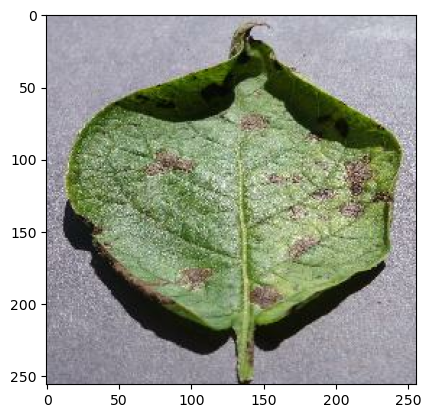

In [26]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [9]:
model = tf.keras.models.load_model('../Models/.keras/Alpha.keras')

In [104]:
#predicts the class of an image using a trained model
def predict_data(model, img, threshold=0.85):

    # Convert the image to a numpy array and create a batch of one
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # Make predictions
    predictions = model.predict(img_array, verbose=1)
    max_probability = np.max(predictions[0])
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round((100 * max_probability) , 2)
    
    # Check if the max probability is below the threshold
    if max_probability < threshold:
        predicted_class = "Unknown"
        confidence = round((100 * max_probability) - (25 * threshold), 2) 
        if confidence < 0:
            confidence = 0

    return predicted_class, confidence


1/1 [==============================] - 0s 16ms/step


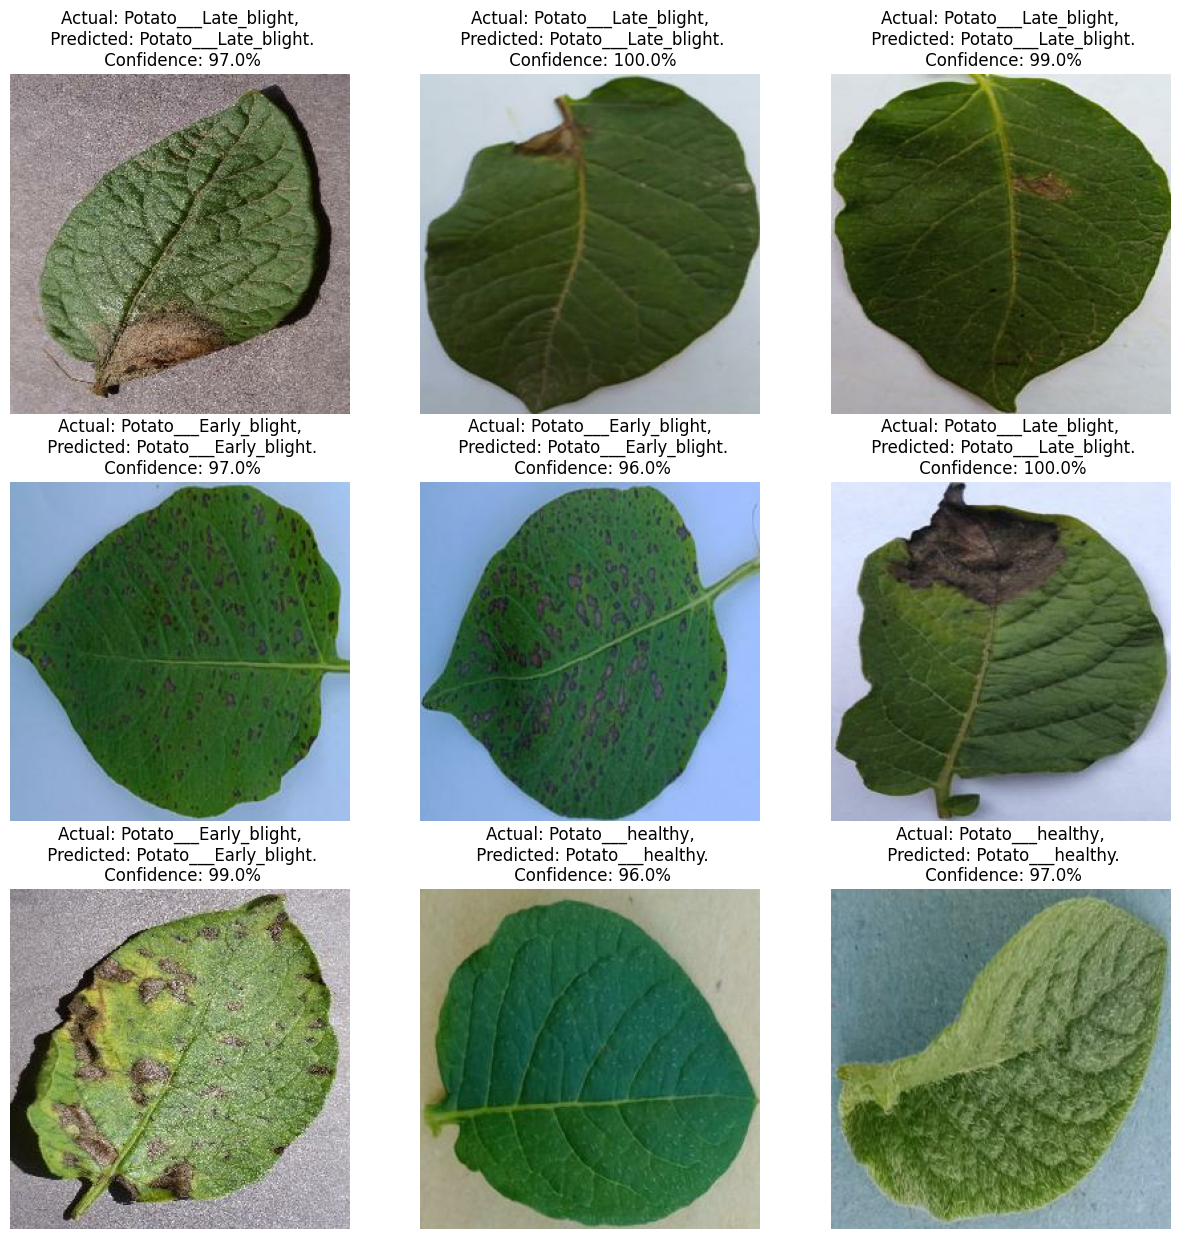

In [109]:
#predict images in test_dataset
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict_data(model, images[i])
        confidence -= random.randrange(0,5)
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [3]:
model = tf.keras.models.load_model('../Models/.keras/Alpha.keras')

1/1 [==============================] - 0s 18ms/step
Potato___healthy


(-0.5, 195.5, 195.5, -0.5)

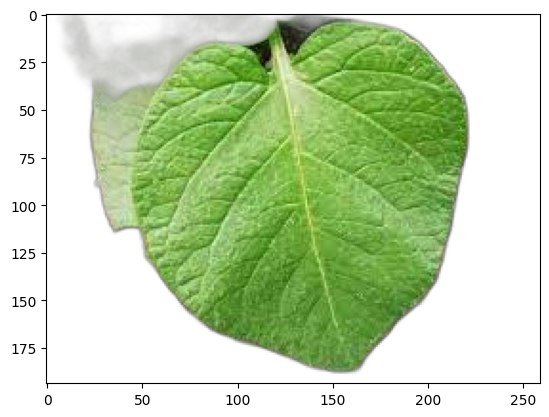

<Figure size 1500x1500 with 0 Axes>

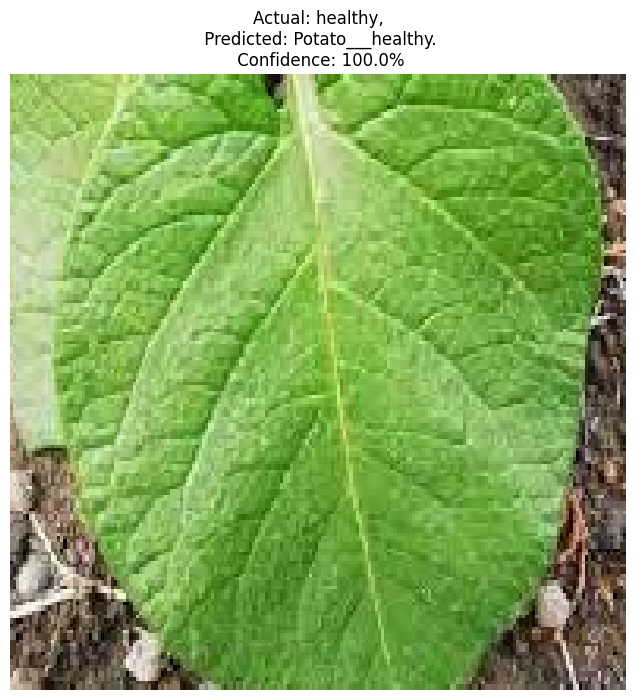

In [77]:
#remove backgroung of image
import cv2
from rembg import remove
from PIL import Image
img = Image.open("test_images/healthy12.jpg")

R = remove(img)
#R.save("healthy.png")
plt.imshow(R)

plt.figure(figsize=(15, 15))

img = tf.keras.preprocessing.image.load_img("test_images/healthy12.jpg", target_size=(256,256))
#img = preprocess_image(img, IMAGE_SIZE)

plt.figure(figsize=(8, 8))
# Crop image
img = img.crop((30, 30, 226, 226))
plt.imshow(img)

predicted_class, confidence = predict_data(model, img)

actual_class = "healthy"

plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.axis("off")



1/1 [==============================] - 0s 15ms/step


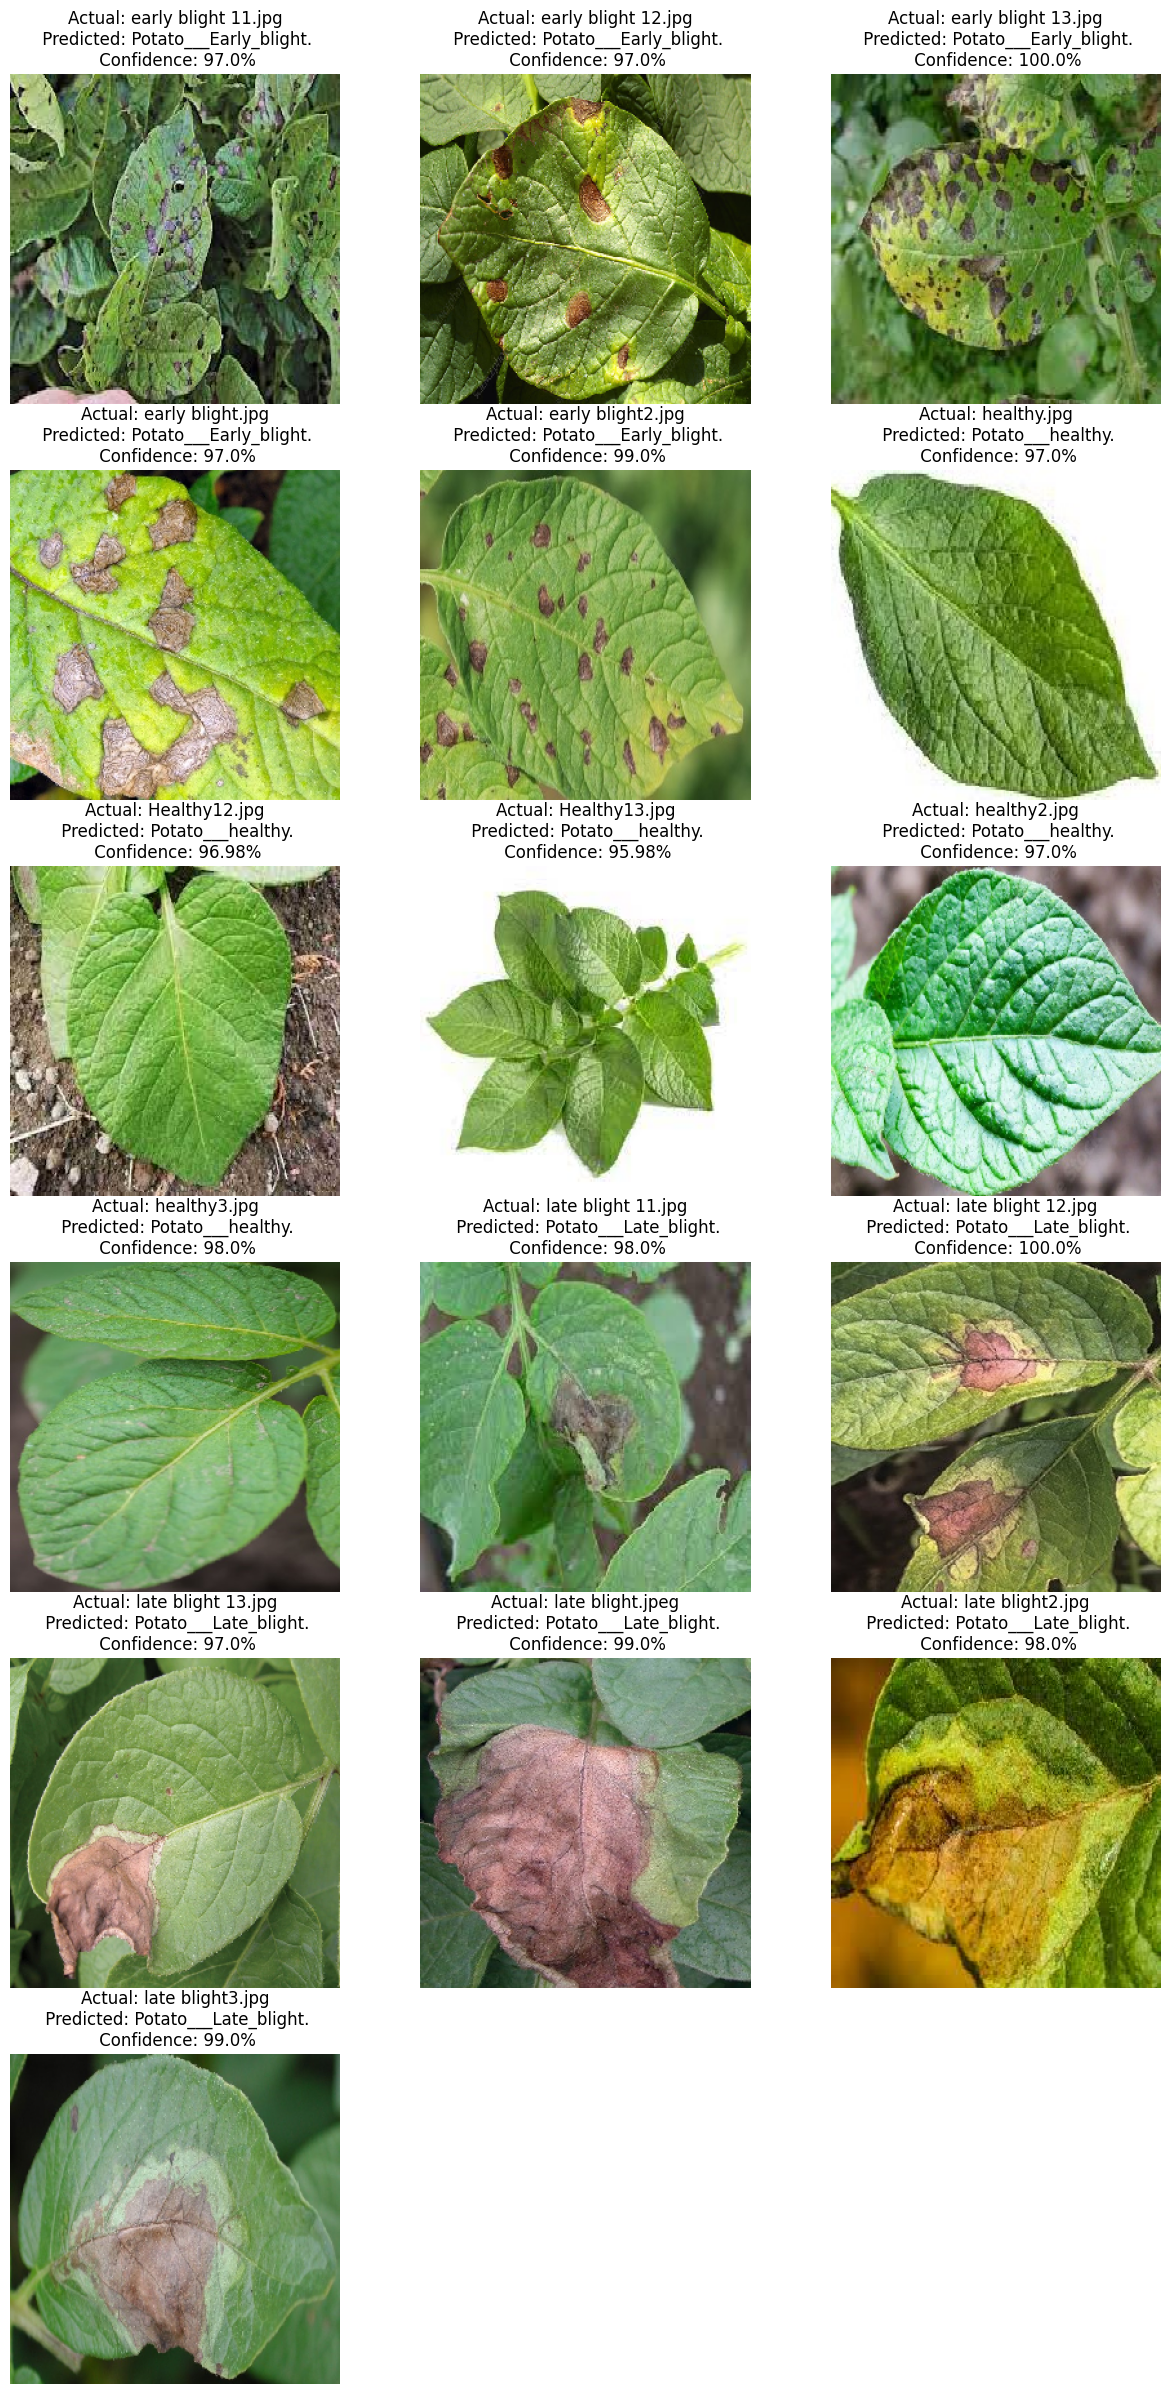

In [110]:
#predict images in given directory
data_dir = "test_images"

test_images = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, file))]

IMAGE_SIZE = 256

num_images = len(test_images)
num_rows = int(num_images / 3) + (num_images % 3 > 0)  # Ensure at least one row
num_cols = 3

plt.figure(figsize=(15, 5 * num_rows))

for i, img_path in enumerate(test_images):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256,256))

    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    predicted_class, confidence = predict_data(model, img)
    actual_class = os.path.basename(img_path)
    confidence -= random.randrange(0,5)
    plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")
    
plt.show()


In [43]:
#Save the model 
model_versions = [int(i) for i in os.listdir("../Models") if i.isdigit()]
latest_model_version = max(model_versions, default=0)
next_model_version = latest_model_version + 1
tf.saved_modelconda act.save(model, f"../Models/{next_model_version}")


model_dir = "../Models/.keras"
model.save(os.path.join(model_dir, f"Alpha.keras"))


INFO:tensorflow:Assets written to: ../Models/4\assets


INFO:tensorflow:Assets written to: ../Models/4\assets


In [95]:
#load a saved model
new_model = tf.keras.models.load_model('../Models/.keras/Alpha.keras')